In [1]:
%run /work/jupyter_notebooks/gene\ family\ distances/correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/duplications/

/work/clusterEvo/new_tests/eggNOG/duplications


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
from scipy.spatial.distance import braycurtis
import igraph as ig
from Bio import SeqIO
import requests

In [3]:
few_duplications = pd.read_parquet('few_duplication_genes.parquet')
few_duplications.head()

,group_id,num_proteins,num_taxa,members,taxa
1217,arCOG00018,195,166,"1006006.Mcup_1244,1033806.HTIA_0702,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1219,arCOG00020,174,158,"1006006.Mcup_1524,1006006.Mcup_1889,1041930.Mt...","[1006006, 1006006, 1041930, 1042877, 1054217, ..."
1227,arCOG00028,108,103,"1041930.Mtc_2182,1070774.J07HN4v3_02653,109498...","[1041930, 1070774, 1094980, 1114856, 1114856, ..."
1228,arCOG00029,170,167,"1006006.Mcup_0319,1033806.HTIA_1327,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1230,arCOG00031,117,100,"1006006.Mcup_0023,1033806.HTIA_1326,1042877.GQ...","[1006006, 1033806, 1042877, 1056495, 1056495, ..."


In [4]:
eggNOG_trees = pd.read_csv('../2157_trees.tsv',
                           sep      ='\t',
                           header   =None,
                           usecols  =[1,2,3],
                           index_col=0,
                           names    =['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=few_duplications.group_id)

In [5]:
group_ids = []
trees     = []
for index, row in eggNOG_trees.iterrows():
    group_ids.append(index)
    trees.append(ete3.Tree(row.tree))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)

table = {group:matrix for group, matrix in zip(group_ids, dist_matrices)}

In [6]:
def run_coevol(matrices):
    m1 = matrices[0].copy()
    m2 = matrices[1].copy()
    return(assess_coevolution(m1, m2, gene_sep='.')[1])

matrix1 = dist_matrices[0].copy()
matrix2 = dist_matrices[1].copy()
run_coevol((matrix1, matrix2))

0.8266284169211484

In [7]:
pool   = multiprocessing.Pool(processes=10)
odr_r2 = pool.map(run_coevol, itertools.combinations(dist_matrices, 2))

In [8]:
group1, group2 = [], []
for n, m in itertools.combinations(group_ids, 2):
    group1.append(n)
    group2.append(m)

In [9]:
odr_df = pd.DataFrame(columns=['group1', 'group2', 'Rsquared'],
                      data   =zip(group1,
                                  group2,
                                  odr_r2))
odr_df.to_parquet('odr_regression_Rsquared.parquet')

In [10]:
odr_df.head()

,group1,group2,Rsquared
0,arCOG00018,arCOG00020,0.826628
1,arCOG00018,arCOG00028,0.931708
2,arCOG00018,arCOG00029,0.757072
3,arCOG00018,arCOG00031,0.894787
4,arCOG00018,arCOG00034,0.910943


In [30]:
def get_jaccard(pair):
    (index1, row1), (index2, row2) = pair
    
    j_index = len(np.intersect1d(row1.taxa, row2.taxa)) /\
              len(np.union1d(    row1.taxa, row2.taxa))
    
    return(row1.group_id, row2.group_id, j_index)

pool            = multiprocessing.Pool(processes=10)
jaccard_indices = pool.map(get_jaccard, itertools.combinations(few_duplications.iterrows(), 2))

In [31]:
jaccard_df = pd.DataFrame(columns=['group1', 'group2', 'jaccard'],
                          data   =jaccard_indices)
jaccard_df.to_parquet('jaccard_indices.parquet')

In [32]:
jaccard_df.head()

,group1,group2,jaccard
0,arCOG00018,arCOG00020,0.928571
1,arCOG00018,arCOG00028,0.610778
2,arCOG00018,arCOG00029,0.982143
3,arCOG00018,arCOG00031,0.592814
4,arCOG00018,arCOG00034,0.910714


In [95]:
def get_braycurtis(pair):
    (index1, row1), (index2, row2) = pair

    taxa1 = re.findall('(?:^|,)(\d+)', row1.members)
    taxa2 = re.findall('(?:^|,)(\d+)', row2.members)

    freq1 = Counter(taxa1)
    freq2 = Counter(taxa2)

    freq1_input = []
    freq2_input = []
    for taxon in set(taxa1).union(taxa2):
        if taxon in freq1:
            freq1_input.append(freq1[taxon])
        else:
            freq1_input.append(0)
        if taxon in freq2:
            freq2_input.append(freq2[taxon])
        else:
            freq2_input.append(0)    
            
    return(row1.group_id, 
           row2.group_id, 
           1 - braycurtis(freq1_input, freq2_input))

pool               = multiprocessing.Pool(processes=10)
braycurtis_indices = pool.map(get_braycurtis, itertools.combinations(few_duplications.iterrows(), 2))

In [96]:
braycurtis_df = pd.DataFrame(columns=['group1', 'group2', 'braycurtis'],
                             data   =braycurtis_indices)
braycurtis_df.to_parquet('braycurtis_indices.parquet')

In [97]:
braycurtis_df.head()

,group1,group2,braycurtis
0,arCOG00018,arCOG00020,0.850949
1,arCOG00018,arCOG00028,0.679868
2,arCOG00018,arCOG00029,0.915068
3,arCOG00018,arCOG00031,0.634615
4,arCOG00018,arCOG00034,0.859551


In [114]:
odr_df['jaccard_product']   = odr_df.Rsquared * jaccard_df.jaccard
odr_df['braycurtis_product']= odr_df.Rsquared * braycurtis_df.braycurtis

In [11]:
import plotly
import chart_studio.plotly as ptl
import plotly.graph_objects as go

ptl.sign_in('lthiberiol', 'm15ikp59lt')

In [ ]:
def balance_matrices_all_combinations(matrix1, matrix2,  gene_sep='_'):
    
    if gene_sep == '_':
        regex = re.compile('^(GC[AF]_\d+(?:\.\d)?)[_|](.*)$')
    elif gene_sep == '.':
        regex = re.compile('^(\d+?)\.(.*)$')
    
    tmp_taxa = []
    for index in matrix1.index:
        genome, gene = re.search(regex, index).groups()
        tmp_taxa.append([index, genome, gene])

    taxa1 = pd.DataFrame(columns=['taxon', 'genome', 'gene'],
                         data=tmp_taxa)

    tmp_taxa = []
    for index in matrix2.index:
        genome, gene = re.search(regex, index).groups()
        tmp_taxa.append([index, genome, gene])

    taxa2 = pd.DataFrame(columns=['taxon', 'genome', 'gene'],
                         data=tmp_taxa)

    shared_genomes = np.intersect1d(taxa1.genome.unique(), 
                                    taxa2.genome.unique())

    taxa1 = taxa1[taxa1.genome.isin(shared_genomes)]
    taxa2 = taxa2[taxa2.genome.isin(shared_genomes)]

    if not taxa1.genome.is_unique or not taxa2.genome.is_unique:
    
        taxa1_frequency = Counter(taxa1.genome) 
        taxa2_frequency = Counter(taxa2.genome)

        for genome in shared_genomes:
            genome1_count = taxa1_frequency[genome]
            genome2_count = taxa2_frequency[genome]

            if genome1_count > 1:
                #
                # one of the matrices must be traversed in the inversed order to make sure an 
                #     all VS all combination is obtained. That is the reason of the "iloc[::-1]"
                #     during the querying
                tmp_df = taxa2.iloc[::-1].query('genome == @genome').copy()
                for _ in range(genome1_count - 1):
                    for index, row in tmp_df.iterrows():
                        tmp_row = row.copy()
                        tmp_row.taxon += f'|{_}'
                        taxa2      = taxa2.append(tmp_row, ignore_index=True)

                        reference_name = re.sub('\|\d+$', '', tmp_row.taxon, flags=re.M)
                        matrix2[    tmp_row.taxon] = matrix2[    reference_name]
                        matrix2.loc[tmp_row.taxon] = matrix2.loc[reference_name]


            if genome2_count > 1:
                tmp_df = taxa1.query('genome == @genome').copy()
                for _ in range(genome2_count - 1):
                    for index, row in tmp_df.iterrows():
                        tmp_row = row.copy()
                        tmp_row.taxon += f'|{_}'
                        taxa1 = taxa1.append(tmp_row, ignore_index=True)

                        reference_name = re.sub('\|\d+$', '', tmp_row.taxon, flags=re.M)
                        matrix1[    tmp_row.taxon] = matrix1[    reference_name]
                        matrix1.loc[tmp_row.taxon] = matrix1.loc[reference_name]

    taxa1.sort_values('genome', inplace=True)
    taxa2.sort_values('genome', inplace=True)

    taxa1.reset_index(drop=True, inplace=True)
    taxa2.reset_index(drop=True, inplace=True)
    
#     return(taxa1, taxa2)
    
    all_taxa_pairs           = pd.DataFrame()
    all_taxa_pairs['taxon1'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                                for taxon in taxa1.taxon]
    all_taxa_pairs['taxon2'] = [re.sub('\|\d$', '', taxon, flags=re.M)
                                for taxon in taxa2.taxon]
    
    matrix1 = matrix1.reindex(index  =taxa1.taxon, 
                              columns=taxa1.taxon, 
                              copy   =True)
    matrix2 = matrix2.reindex(index  =taxa2.taxon, 
                              columns=taxa2.taxon, 
                              copy   =True)
    
    return(matrix1, taxa1, matrix2, taxa2)

In [ ]:
duplicated_taxa = set()

tmp = few_duplications.iloc[0]
duplicated_taxa1 = set()
for taxa in tmp.taxa:
    if tmp.members.count(str(taxa)) > 1:
        duplicated_taxa1.add(str(taxa))
        duplicated_taxa.add(str(taxa))

tmp = few_duplications.iloc[1]
duplicated_taxa2 = set()
for taxa in tmp.taxa:
    if tmp.members.count(str(taxa)) > 1:
        duplicated_taxa2.add(str(taxa))
        duplicated_taxa.add(str(taxa))

In [ ]:
matrix1, taxa1, matrix2, taxa2 = balance_matrices_all_combinations(dist_matrices[0].copy(), 
                                                                   dist_matrices[1].copy(), 
                                                                   gene_sep='.')

In [ ]:
triu_indices = np.triu_indices_from(matrix1, k=1)
condensed1   = matrix1.values[triu_indices]
condensed2   = matrix2.values[triu_indices]

matrix1_label = [f'{index1} VS {index2}' for index1, index2 in zip(matrix1.index[triu_indices[0]],
                                                                   matrix1.index[triu_indices[1]])]
matrix2_label = [f'{index1} VS {index2}' for index1, index2 in zip(matrix2.index[triu_indices[0]],
                                                                   matrix2.index[triu_indices[1]])]

combined_labels = [f'{label1}<br>{label2}' for label1, label2 in zip(matrix1_label,
                                                                   matrix2_label)]

In [ ]:
trace_data = {genome:{'x':[], 'y':[], 'c':[], 'l':[]} for genome in duplicated_taxa}
trace_data['no duplication'] = {'x':[], 'y':[], 'c':[], 'l':[]}

all_combined = {'x':[], 'y':[], 'c':[], 'l':[]}

In [ ]:
for label1, label2, pos1, pos2 in zip(matrix1_label, matrix2_label, condensed1, condensed2):
    label1_taxa = re.search('^(\d+?)\.\S+ VS (\d+?)\.', label1, re.M).groups()
    label2_taxa = re.search('^(\d+?)\.\S+ VS (\d+?)\.', label2, re.M).groups()
    
    tmp_duplicated = duplicated_taxa.intersection(
        np.intersect1d(label1_taxa, label2_taxa).tolist()
    )
    
    all_combined['x'].append(pos1)
    all_combined['y'].append(pos2)
    all_combined['c'].append('blue')
    all_combined['l'].append(f'{label1}<br>{label2}')
    
    if tmp_duplicated:
        for tmp in tmp_duplicated:
            trace_data[tmp]['x'].append(pos1)
            trace_data[tmp]['y'].append(pos2)
            trace_data[tmp]['c'].append('red')
            trace_data[tmp]['l'].append(f'{label1}<br>{label2}')
    else:
        trace_data['no duplication']['x'].append(pos1)
        trace_data['no duplication']['y'].append(pos2)
        trace_data['no duplication']['c'].append('black')
        trace_data['no duplication']['l'].append(f'{label1}<br>{label2}')

In [ ]:
# possible_colors = '#2E8A79 #4071BF #9D3467 #462163 #AC3B39 #2A4F7E #28772A #BB3EAD #B0933B'.split()
# possible_shapes = 'square x triangle-up star'.split()

# styles = itertools.product(possible_colors, possible_shapes)

data = []
for name in trace_data.keys():
    
    if name == 'no duplication':
        tmp_color, tmp_shape = ['black', 'circle']
    else:
        tmp_color, tmp_shape = ['red', 'x']
        
    data.append(
        go.Scatter(
            x        = trace_data[name]['x'],
            y        = trace_data[name]['y'],
            text     = trace_data[name]['l'],
            mode     ='markers',
            name     = name,
            hoverinfo='text',
            opacity  =0.7,
            marker   =dict(symbol      =tmp_shape,
                           color       =tmp_color,
                           size        =10,
                           line_width  =1,
                           line_color  ='white')

        )
    )

In [ ]:
fig = go.Figure(data=list(reversed(data)), # here is important to add edges first so they don't cover nodes
                layout=go.Layout(template          ='simple_white',
                                 title             ='All possible combinations of duplicated genes',
                                 titlefont_size    =16,
                                 showlegend        =True,
                                 legend_orientation='h',
                                 hovermode         ='closest',
                                 margin            =dict(b=20,
                                                         l=5,
                                                         r=5,
                                                         t=40),
#                                  xaxis             =dict(showgrid     =False,
#                                                          zeroline     =False,
#                                                          showticklabels=False),
#                                  yaxis             =dict(showgrid      =False, 
#                                                          zeroline      =False, 
#                                                          showticklabels=False)
                                )
                )

plotly.offline.plot(fig, filename='/Users/thiberio/duplication_test_all.html', config={'scrollZoom': True}, auto_open=False)

In [ ]:
matrix1, taxa1, matrix2, taxa2 = balance_matrices(dist_matrices[0].copy(), 
                                                  dist_matrices[1].copy(), 
                                                  gene_sep='.')

In [ ]:
triu_indices = np.triu_indices_from(matrix1, k=1)
condensed1   = matrix1.values[triu_indices]
condensed2   = matrix2.values[triu_indices]

matrix1_label = [f'{index1} VS {index2}' for index1, index2 in zip(matrix1.index[triu_indices[0]],
                                                                   matrix1.index[triu_indices[1]])]
matrix2_label = [f'{index1} VS {index2}' for index1, index2 in zip(matrix2.index[triu_indices[0]],
                                                                   matrix2.index[triu_indices[1]])]

combined_labels = [f'{label1}<br>{label2}' for label1, label2 in zip(matrix1_label,
                                                                   matrix2_label)]

In [ ]:
trace_data = {genome:{'x':[], 'y':[], 'c':[], 'l':[]} for genome in duplicated_taxa}
trace_data['no duplication'] = {'x':[], 'y':[], 'c':[], 'l':[]}

all_combined = {'x':[], 'y':[], 'c':[], 'l':[]}

In [ ]:
for label1, label2, pos1, pos2 in zip(matrix1_label, matrix2_label, condensed1, condensed2):
    label1_taxa = re.search('^(\d+?)\.\S+ VS (\d+?)\.', label1, re.M).groups()
    label2_taxa = re.search('^(\d+?)\.\S+ VS (\d+?)\.', label2, re.M).groups()
    
    tmp_duplicated = duplicated_taxa.intersection(
        np.intersect1d(label1_taxa, label2_taxa).tolist()
    )
    
    all_combined['x'].append(pos1)
    all_combined['y'].append(pos2)
    all_combined['c'].append('blue')
    all_combined['l'].append(f'{label1}<br>{label2}')
    
    if tmp_duplicated:
        for tmp in tmp_duplicated:
            trace_data[tmp]['x'].append(pos1)
            trace_data[tmp]['y'].append(pos2)
            trace_data[tmp]['c'].append('blue')
            trace_data[tmp]['l'].append(f'{label1}<br>{label2}')
    else:
        trace_data['no duplication']['x'].append(pos1)
        trace_data['no duplication']['y'].append(pos2)
        trace_data['no duplication']['c'].append('black')
        trace_data['no duplication']['l'].append(f'{label1}<br>{label2}')

In [ ]:
# possible_colors = '#2E8A79 #4071BF #9D3467 #462163 #AC3B39 #2A4F7E #28772A #BB3EAD #B0933B'.split()
# possible_shapes = 'square x triangle-up star'.split()

# styles = itertools.product(possible_colors, possible_shapes)

data = []
for name in trace_data.keys():
    
    if name == 'no duplication':
        tmp_color, tmp_shape = ['black', 'circle']
    else:
        tmp_color, tmp_shape = ['blue', 'x']
        
    data.append(
        go.Scatter(
            x        = trace_data[name]['x'],
            y        = trace_data[name]['y'],
            text     = trace_data[name]['l'],
            mode     ='markers',
            name     = name,
            hoverinfo='text',
            opacity  =0.7,
            marker   =dict(symbol      =tmp_shape,
                           color       =tmp_color,
                           size        =10,
                           line_width  =1,
                           line_color  ='white')

        )
    )

In [ ]:
fig = go.Figure(data=list(reversed(data)), # here is important to add edges first so they don't cover nodes
                layout=go.Layout(template          ='simple_white',
                                 title             ='Best matching duplicates only',
                                 titlefont_size    =16,
                                 showlegend        =True,
                                 legend_orientation='h',
                                 hovermode         ='closest',
                                 margin            =dict(b=20,
                                                         l=5,
                                                         r=5,
                                                         t=40),
#                                  xaxis             =dict(showgrid     =False,
#                                                          zeroline     =False,
#                                                          showticklabels=False),
#                                  yaxis             =dict(showgrid      =False, 
#                                                          zeroline      =False, 
#                                                          showticklabels=False)
                                )
                )

plotly.offline.plot(fig, filename='/Users/thiberio/duplication_test_matching.html', config={'scrollZoom': True}, auto_open=False)

In [115]:
odr_df.head()

,group1,group2,Rsquared,jaccard_product,braycurtis_product
0,arCOG00018,arCOG00020,0.826628,0.767584,0.703418
1,arCOG00018,arCOG00028,0.931708,0.569067,0.633438
2,arCOG00018,arCOG00029,0.757072,0.743553,0.692772
3,arCOG00018,arCOG00031,0.894787,0.530443,0.567846
4,arCOG00018,arCOG00034,0.910943,0.829609,0.783001


In [117]:
data_columns = ['Rsquared', 'jaccard_product', 'braycurtis_product']

In [118]:
string = pd.read_parquet('few_duplications-string.parquet')

string['group_pair'] = string[['group1', 'group2']].agg(frozenset, axis=1)
string.drop_duplicates(subset='group_pair', inplace=True)

strongly_related = string.query('combined_score >= 900')
weakly_related   = string.query('combined_score <= 200')

odr_df['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)

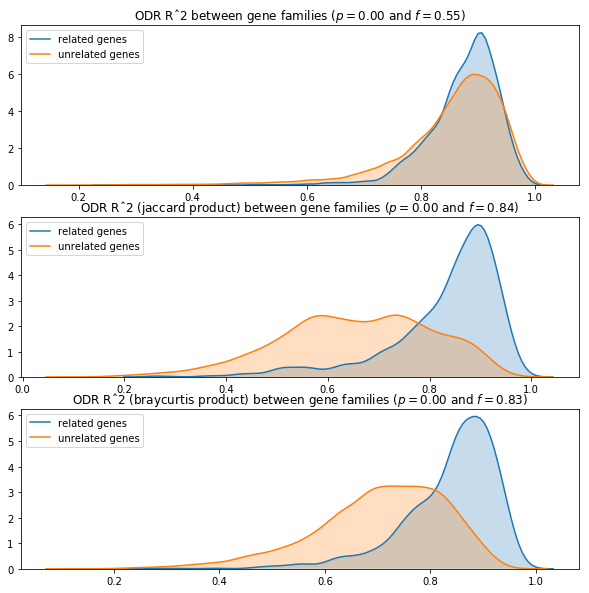

In [124]:
fig, axs = plt.subplots(nrows=3, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    strong_odr = odr_df.query('group_pair in @strongly_related.group_pair')[column].values
    weak_odr   = odr_df.query('group_pair in @weakly_related.group_pair'  )[column].values

    hypothesis = mannwhitneyu(weak_odr,
                              strong_odr)
    effect_size = cles(weak_odr, strong_odr)

    sns.kdeplot(strong_odr, shade=True, label='related genes',   ax=ax)
    sns.kdeplot(weak_odr,   shade=True, label='unrelated genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR Rˆ2 ({column.replace("_", " ")}) between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

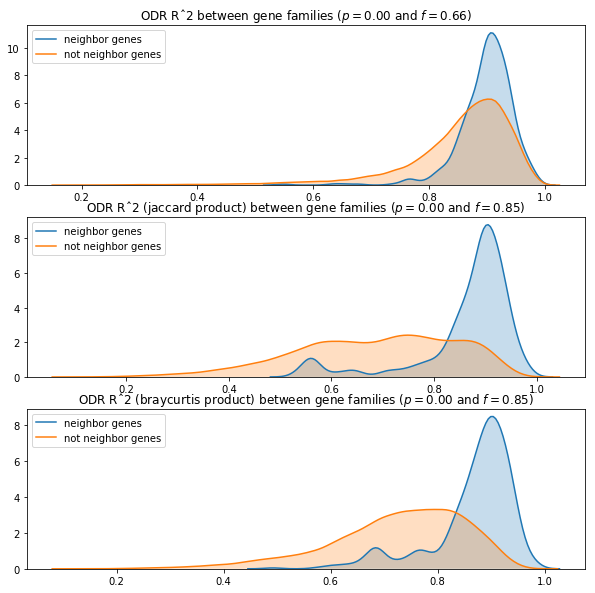

In [126]:
fig, axs = plt.subplots(nrows=3, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    neighors     = string.query('neighborhood >= 700')
    not_neighors = string.query('neighborhood <= 200')

    neighors_odr     = odr_df.query('group_pair in @neighors.group_pair'    )[column].values
    not_neighors_odr = odr_df.query('group_pair in @not_neighors.group_pair')[column].values

    hypothesis = mannwhitneyu(not_neighors_odr,
                              neighors_odr)
    effect_size = cles(not_neighors_odr, neighors_odr)

    sns.kdeplot(neighors_odr, shade=True,     label='neighbor genes',     ax=ax)
    sns.kdeplot(not_neighors_odr, shade=True, label='not neighbor genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR Rˆ2 ({column.replace("_", " ")}) between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

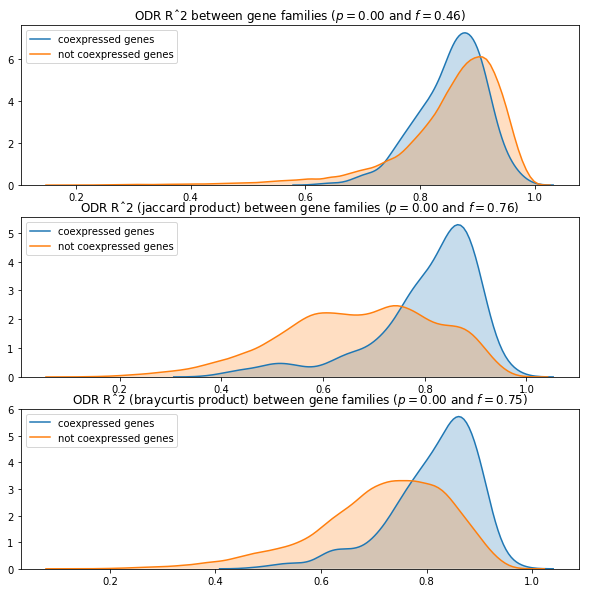

In [128]:
fig, axs = plt.subplots(nrows=3, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    coexpressed     = string.query('coexpression >= 700')
    not_coexpressed = string.query('coexpression <= 200')

    coexpressed_odr     = odr_df.query('group_pair in @coexpressed.group_pair'    )[column].values
    not_coexpressed_odr = odr_df.query('group_pair in @not_coexpressed.group_pair')[column].values

    hypothesis = mannwhitneyu(not_coexpressed_odr,
                              coexpressed_odr)
    effect_size = cles(not_coexpressed_odr, coexpressed_odr)

    sns.kdeplot(coexpressed_odr, shade=True,     label='coexpressed genes', ax=ax)
    sns.kdeplot(not_coexpressed_odr, shade=True, label='not coexpressed genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR Rˆ2 ({column.replace("_", " ")}) between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');